# Predict by the approximate expression of 'count_item'
This kernel shows an example of approximation using `scipy.optimize.curve_fit()`.<BR>
I've even submitted, but please **note** that this kernel alone isn't enough to solve the "Predict Future Sales" competition.

The sales number history of item is expressed by an **approximate expression**, and the sales number at 'date_block_num'= 34 is estimated. I tried using the **Skew nomal distribution**, but in many cases it failed to generate an approximate expression, so I changed it to the **Beta distribution**.
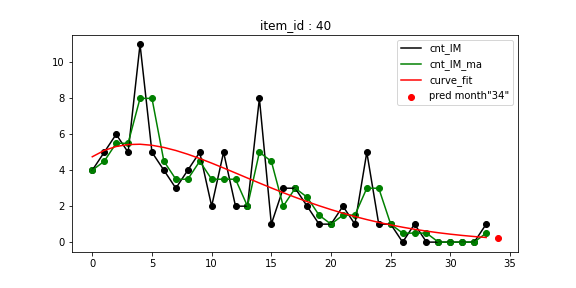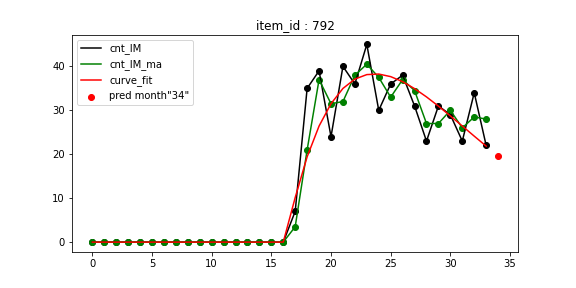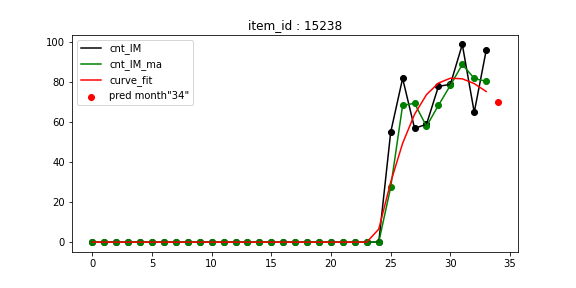
* It may be improved a little by adding seasonal periodicity correction.

In [ ]:
import os
import time
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
### Kaggle or Local-PC ###
KAGGLE = True       # <==== SET ============

if KAGGLE:
    DIR = '../input/competitive-data-science-predict-future-sales'
else:              # local PC
    DIR = './competitive-data-science-predict-future-sales/'

In [ ]:
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load Data

In [ ]:
sales = pd.read_csv(os.path.join(DIR, "sales_train.csv"))
test = pd.read_csv(os.path.join(DIR, "test.csv"))

In [ ]:
sales

In [ ]:
test

## Data Cleaning and Aggregation

### Remove outliers
What's negative for 'item_price' and 'item_cnt_day'?
Is it a return or is it just incorrect data?

In [ ]:
sales = sales[(sales['item_price'] > 0)
              & (sales['item_cnt_day'] > 0)].reset_index(drop = True)
sales

### Aggregate daily data into monthly data 

In [ ]:
sales = (sales.groupby(['date_block_num','shop_id','item_id'])
         .agg({'item_cnt_day':'sum'}).reset_index())
sales.columns = ['date_block_num','shop_id','item_id','cnt_SIM']
sales

## Sales history of each item

In [ ]:
# Create item_month DataFrame
item_month_df = pd.DataFrame(product(sales['item_id'].unique(),
                                     range(34)))
item_month_df.columns = ['item_id', 'date_block_num']
item_month_df = item_month_df.sort_values(['item_id', 'date_block_num'])

In [ ]:
# Add 'cnt_IM'
group = sales.groupby(['date_block_num','item_id']).agg({'cnt_SIM':'sum'}).reset_index()
group.columns = ['date_block_num','item_id','cnt_IM']
item_month_df = pd.merge(item_month_df, group,
                         on = ['item_id','date_block_num'],
                         how = 'left').fillna(0)

# Add 'cnt_IM_ma'(ma:moving average)
item_month_df['cnt_IM_ma'] = (item_month_df.groupby('item_id')['cnt_IM']
#                                .rolling(3, center=True, min_periods=1)
                               .rolling(3, min_periods = 1)
                               .mean()).reset_index()['cnt_IM'].fillna(0)

item_month_df

## Create Approximate Formula and Predict
Create an approximate expression based on the formula of **Beta distribution**. And Calculate 'item_cnt_month' for 'date_block_num' = 34

### Beta distribution based

In [ ]:
from scipy import optimize, stats

# Approximate Formula (Beta distribution based)
def formula(x, A, a, b, alpha):
    # Scale conversion on the horizontal axis
    if a + 0.2 > b:
        b = max(0.2, a + 0.2)
    x = (b - a) / 33 * x + a
    # Beta distribution is defined by range [0, 1]
    x = np.clip(x, 0.0, 1.0)
    # Probability density function
    y = A * stats.beta.pdf(x, alpha, 10 - alpha, loc=0, scale=1)
    return y

# calculate
def culc(x, p):
    return formula(x, *p)
    
# curve_fit and calculate
def fit(y):
    try:
        peak_x = (np.where(y == y.max())[0] / 33)[0]
        p, _ = optimize.curve_fit(formula, x, y,
                                  # Initial for the parameters
                                  p0 = [y.max(), 0.5-peak_x, 1.5-peak_x, 5.],
                                  # Bounds on parameters
                                  bounds = ([0.1, -3., 0.2, 2.],
                                            [100000., 0.5, 3., 8.]),
                                 )
    except RuntimeError:    # least-squares minimization fails
        p = [1., 0, 1, 5.]
    return p

# predict
def pred(y):
    return culc(34, fit(y))

### Skew normal distribution based

In [ ]:
# from scipy import optimize
# from scipy.special import erf
# from numpy import exp, sqrt, pi

# # probability distribution function
# def pdf(x):
#     return 1 / sqrt(2 * pi) * exp(-x * x / 2.0)

# # cumulative distribution function
# def cdf(x):
#     return (1.0 + erf(x / sqrt(2.))) / 2.

# # Approximate Formula (skew normal distribution based)
# def formula(x, a, mu, sig, lam):
#     z = (x - mu) / sig
#     y = a * 2. / sig * pdf(z) * cdf(lam * (x - mu))
#     return y

# # calculate
# def culc(x, p):
#     return formula(x, *p)
    
# # curve_fit and calculate
# def fit(y):
#     try:
#         p, _ = optimize.curve_fit(formula, x, y,
#                                   p0 = [100., 25., 5., 0.],
#                                   method = 'dogbox' #{lm’,trf’,'dogbox’}
#                                  )
#     except RuntimeError:    # least-squares minimization fails
#         p = [1., 16., 5., 0.]
#     return p

# # predict
# def pred(y):
#     return culc(34, fit(y))

### Example

In [ ]:
idx = 792        # example item_id

x = np.array(range(34))
y = item_month_df.loc[item_month_df['item_id']==idx, 'cnt_IM']
y0 = item_month_df.loc[item_month_df['item_id']==idx, 'cnt_IM_ma']

# Create Approximate Formula and Predict 'date_block_num'=34.
p = fit(y0)
y_pred = culc(34, p)

print(f'p[a, mue, sigma, lambda] = {p}')
print(f'y_pred = {y_pred}')

In [ ]:
# plot
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)

ax.plot(x, y, c = 'k', label = 'cnt_IM')
ax.scatter(x, y, c = 'k')
ax.plot(x, y0, c = 'g', label = 'cnt_IM_ma')
ax.scatter(x, y0, c = 'g')
ax.plot(x, culc(x, p), c = 'r', label = 'curve_fit')
ax.scatter(34, y_pred, c = 'r', label = 'pred month"34"')
plt.title(f'item_id : {idx}')
plt.legend()

## Predict all items

In [ ]:
ts = time.time()

# Predict number of sales of each item in date_block_num:34.
y_preds = (item_month_df
           .groupby(['item_id'])['cnt_IM_ma']
           .apply(pred))

time.time() - ts

In [ ]:
# cnt_I_34'(Number of sales of each item in date_block_num:34)
cnt_df = pd.DataFrame({'item_id':item_month_df['item_id'].unique(),
                       'cnt_I_34':y_preds}).reset_index(drop = True)
cnt_df['cnt_I_34'] = np.clip(cnt_df['cnt_I_34'], 0, 400)
cnt_df

### Distribute to each shop

In [ ]:
# Create shop_item DataFrame
shop_item_df = pd.DataFrame(product(sales['shop_id'].unique(),
                                    sales['item_id'].unique()))
shop_item_df.columns = ['shop_id', 'item_id']
shop_item_df = shop_item_df.sort_values(['shop_id', 'item_id'])

In [ ]:
# Add 'cnt_SI'(Number of sales of each item for each store)
group = (sales
         .groupby(['item_id', 'shop_id'])['cnt_SIM']
         .agg('sum')).reset_index()
group.columns = ['item_id','shop_id','cnt_SI']
shop_item_df = pd.merge(shop_item_df, group,
                        on = ['item_id','shop_id'],
                        how = 'left').fillna(0)

# Add 'cnt_I'(Number of sales of each item)
group = (sales
         .groupby(['item_id'])['cnt_SIM']
         .agg('sum')).reset_index()
group.columns = ['item_id','cnt_I']
shop_item_df = pd.merge(shop_item_df, group,
                        on = ['item_id'],
                        how = 'left')

# Add 'cnt_I_34'(Number of sales of each item in date_block_num:34)
shop_item_df = pd.merge(shop_item_df, cnt_df, on = 'item_id', how = 'left')

# Add 'item_cnt_month'
shop_item_df['item_cnt_month'] = (shop_item_df['cnt_I_34']
                                  * shop_item_df['cnt_SI']
                                  / shop_item_df['cnt_I']).clip(0, 20)

shop_item_df

## submission

In [ ]:
test = (pd.merge(test, shop_item_df,
                 on = ['shop_id','item_id'], how = 'left')
        .fillna(0))
test

In [ ]:
submission = test[['ID','item_cnt_month']]
submission

In [ ]:
submission.to_csv('submission.csv', index = False)